In [1]:
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
import keras.utils 
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
#import warnings
#warnings.filterwarnings("ignore")
%matplotlib inline

print("hi")

2024-10-15 13:40:48.321571: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 13:40:48.322257: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 13:40:48.326372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-15 13:40:48.338871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 13:40:48.359516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

hi


In [2]:
import os
import numpy as np
import cv2
import skimage.transform
from tqdm import tqdm
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

imageSize = 50
train_dir = "/home/ubuntu/mymodel/Expresshio/asl_alphabet_train/asl_alphabet_train"
test_dir = "/home/ubuntu/mymodel/Expresshio/asl_alphabet_test/asl_alphabet_test"

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    labels = {label: idx for idx, label in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 
                                                       'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 
                                                       'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 
                                                       'Z', 'del', 'nothing', 'space'])}
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.') and folderName in labels:
            label = labels[folderName]
            for image_filename in tqdm(os.listdir(os.path.join(folder, folderName))):
                img_path = os.path.join(folder, folderName, image_filename)
                img_file = cv2.imread(img_path)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    X.append(img_file)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

X_train, y_train = get_data(train_dir)

# Check if X_train is empty
if len(X_train) == 0 or len(y_train) == 0:
    raise ValueError("No images were loaded. Please check your dataset paths.")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

# Encode labels to one-hot vectors
y_trainHot = to_categorical(y_train, num_classes=30)
y_testHot = to_categorical(y_test, num_classes=30)

# Check the shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_trainHot.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_testHot.shape}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 322.47it/s]


X_train shape: (69600, 50, 50, 3), y_train shape: (69600, 30)
X_test shape: (17400, 50, 50, 3), y_test shape: (17400, 30)


In [3]:
from sklearn.utils import shuffle
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]
print("hi")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_trainHot.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_testHot.shape}")


hi
X_train shape: (30000, 50, 50, 3), y_train shape: (30000, 30)
X_test shape: (17400, 50, 50, 3), y_test shape: (17400, 30)


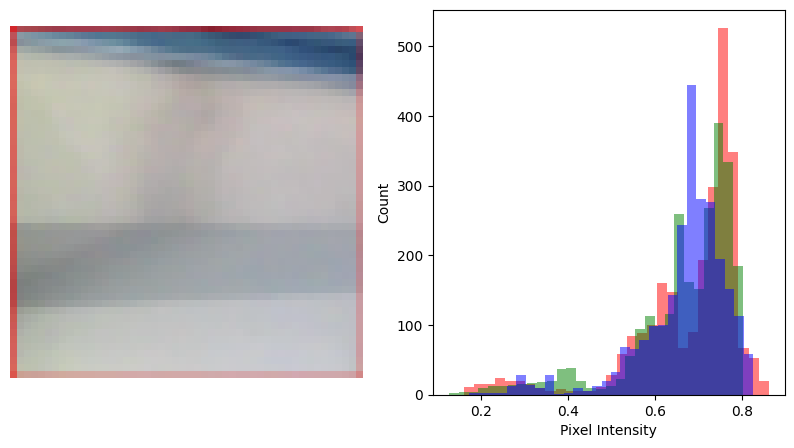

In [4]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

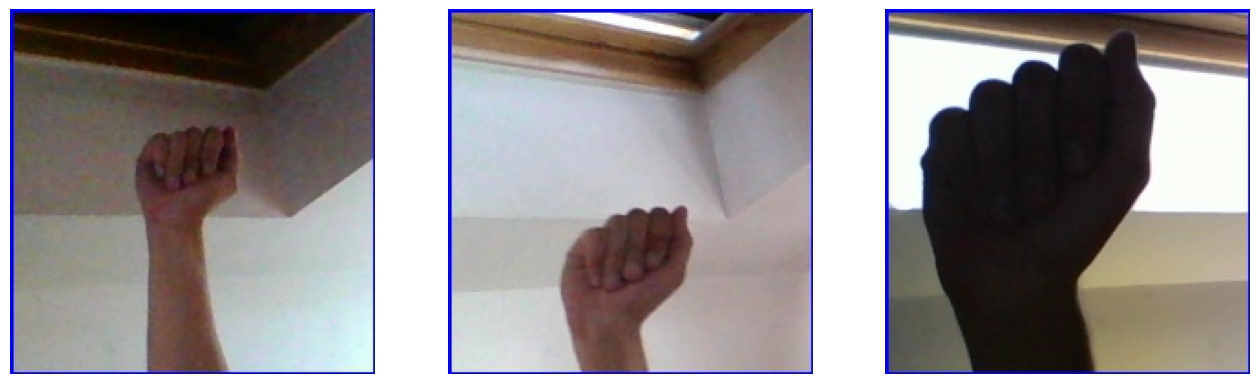

In [5]:
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Assuming you have already defined multipleImages
multipleImages = glob('asl_alphabet_train/asl_alphabet_train/A/**')

def plotThreeImages(images):
    # Check if there are at least 3 images
    num_images = len(images)
    if num_images < 3:
        raise ValueError(f"Not enough images to sample. Available: {num_images}")

    # Randomly sample 3 images
    r = random.sample(images, 3)
    
    plt.figure(figsize=(16, 16))
    
    # Plot each image
    for i in range(3):
        img = cv2.imread(r[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide axes
    
    plt.show()  # Show the plot

# Call the function to plot three images
plotThreeImages(multipleImages)


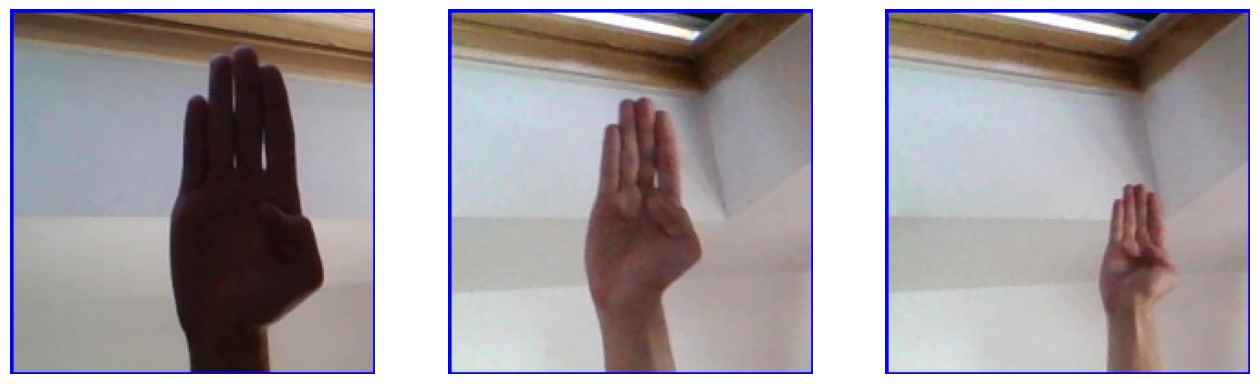

In [6]:
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Load images from a specific directory
multipleImages = glob('asl_alphabet_train/asl_alphabet_train/B/**')

def plotThreeImages(images):
    # Check if there are at least 3 images available
    if len(images) < 3:
        print(f"Not enough images to sample. Available: {len(images)}")
        return

    # Randomly sample 3 images
    r = random.sample(images, 3)
    
    plt.figure(figsize=(16, 16))
    
    # Plot each image
    for i in range(3):
        img = cv2.imread(r[i])
        if img is None:
            print(f"Error reading image: {r[i]}")
            continue  # Skip if image is not found
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide axes
    
    plt.show()  # Show the plot

# Call the function to plot three images
plotThreeImages(multipleImages)


A
Number of images found: 3000


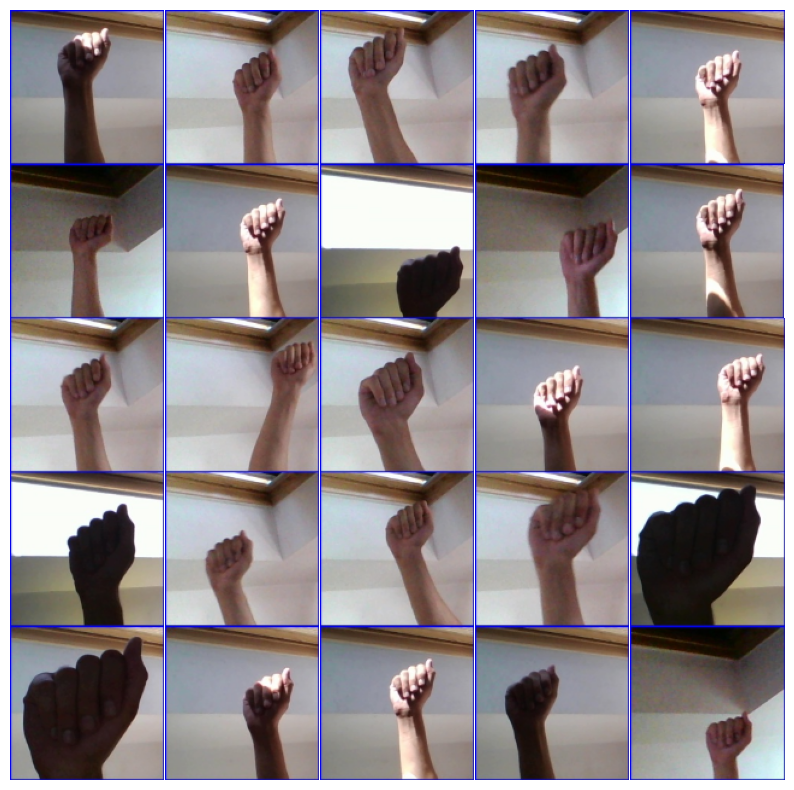

In [7]:

# Load images from the specified directory
print("A")
multipleImages = glob('asl_alphabet_train/asl_alphabet_train/A/**')

# Check if any images were found
if not multipleImages:
    print("No images found in the specified directory.")
else:
    print(f"Number of images found: {len(multipleImages)}")

# Initialize the plot parameters
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images
for l in multipleImages[:25]:
    im = cv2.imread(l)
    
    # Check if the image was loaded successfully
    if im is None:
        print(f"Error loading image: {l}")
        continue  # Skip to the next image if there was an error

    im = cv2.resize(im, (128, 128))  # Resize the image
    plt.subplot(5, 5, i_ + 1)  # Create a 5x5 grid of subplots
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.axis('off')  # Hide axis
    i_ += 1

plt.show()  # Show the plot after all images have been added

B
Number of images found: 3000


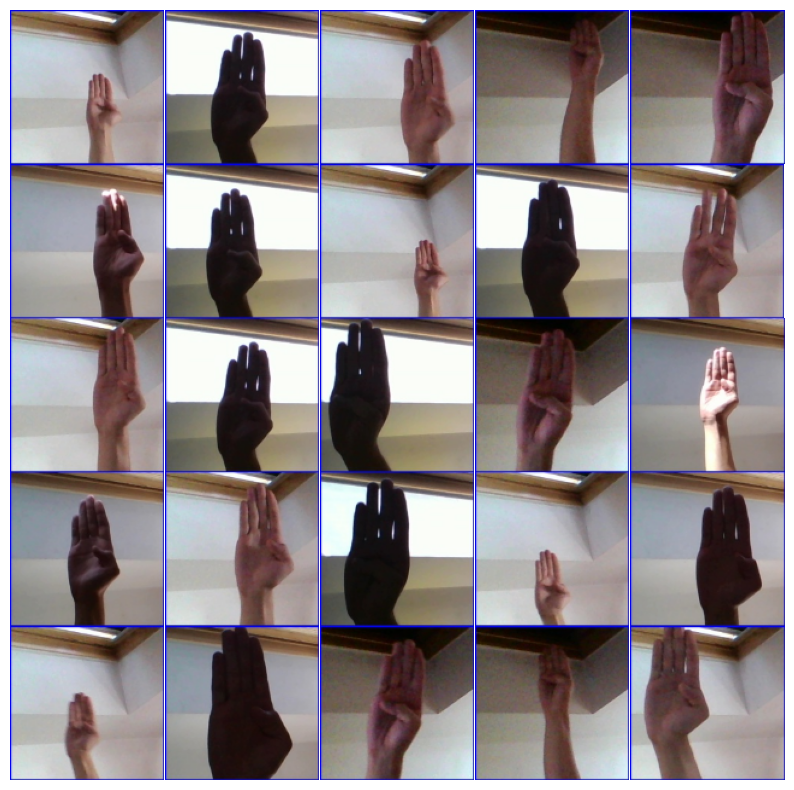

In [8]:
print("B")
multipleImages = glob('asl_alphabet_train/asl_alphabet_train/B/**')

# Check if any images were found
if not multipleImages:
    print("No images found in the specified directory.")
else:
    print(f"Number of images found: {len(multipleImages)}")

# Initialize the plot parameters
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)

# Loop through the first 25 images
for l in multipleImages[:25]:
    im = cv2.imread(l)
    
    # Check if the image was loaded successfully
    if im is None:
        print(f"Error loading image: {l}")
        continue  # Skip to the next image if there was an error

    im = cv2.resize(im, (128, 128))  # Resize the image
    plt.subplot(5, 5, i_ + 1)  # Create a 5x5 grid of subplots
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    plt.axis('off')  # Hide axis
    i_ += 1

plt.show()  # Show the plot after all images have been added

Shape of y_train: (69600,)


/tmp/ipykernel_10432/4029451581.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=df, palette='viridis')


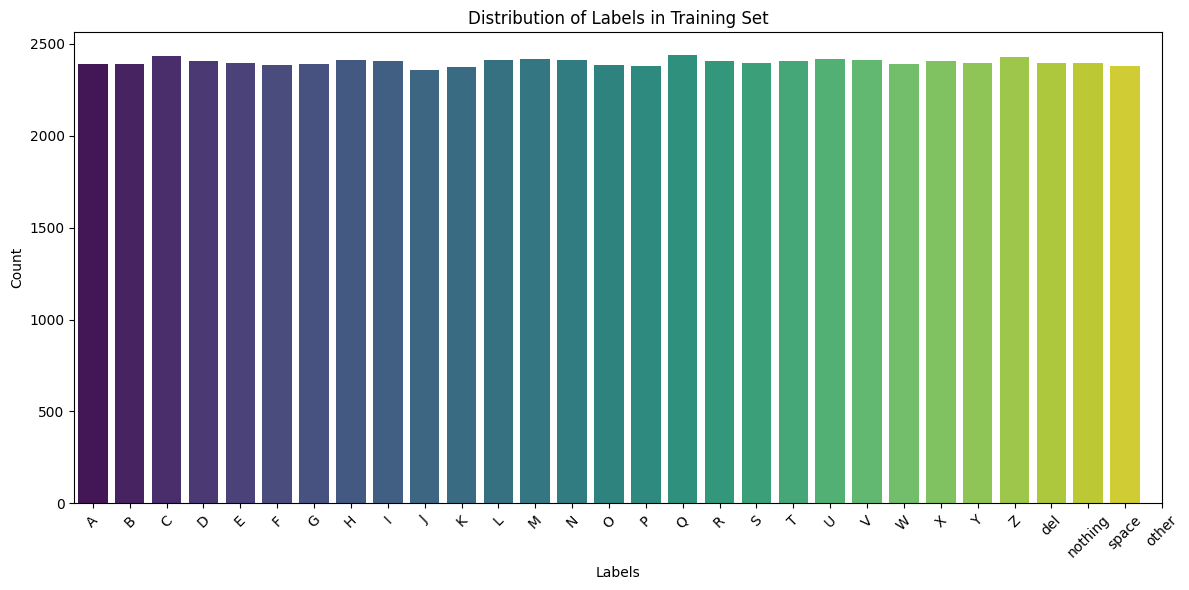

Character Mapping:
0: A
1: B
2: C
3: D
4: E
5: F
6: G
7: H
8: I
9: J
10: K
11: L
12: M
13: N
14: O
15: P
16: Q
17: R
18: S
19: T
20: U
21: V
22: W
23: X
24: Y
25: Z
26: del
27: nothing
28: space
29: other


In [9]:
print("Shape of y_train:", y_train.shape)

# Convert one-hot encoded labels to class indices or use directly if it's 1D
if y_train.ndim == 2:
    y_train_labels = np.argmax(y_train, axis=1)
elif y_train.ndim == 1:
    y_train_labels = y_train
else:
    raise ValueError("Unexpected shape of y_train. It must be either 1D or 2D.")

# Create a mapping from label index to character
map_characters = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 
    5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
    10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 
    15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 
    20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 
    25: 'Z', 26: 'del', 27: 'nothing', 28: 'space', 29: 'other'
}

# Create a DataFrame for plotting
df = pd.DataFrame()
df["labels"] = y_train_labels

# Visualize the distribution of labels
plt.figure(figsize=(12, 6))
sns.countplot(x='labels', data=df, palette='viridis')
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Labels')
plt.ylabel('Count')

# Set x-ticks to show corresponding characters
plt.xticks(ticks=range(len(map_characters)), labels=[map_characters[i] for i in range(len(map_characters))], rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

# Print the character mapping
print("Character Mapping:")
for key, value in map_characters.items():
    print(f"{key}: {value}")

In [10]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [8]:
import numpy as np
from sklearn.utils import class_weight
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.applications import VGG16
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import itertools
map_characters1 = map_characters
# Assuming y_train is your target labels in one-hot encoded format
# Check if y_train is one-hot encoded and convert to class labels
if y_train.ndim == 2:  # Check if y_train is 2D (one-hot encoded)
    y_train_labels = np.argmax(y_train, axis=1)
else:
    y_train_labels = y_train  # Directly use if already in integer format

# Compute class weights
class_weight1 = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)

# Proceed with the model setup and training
weight_path1 = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights=weight_path1, include_top=False, input_shape=(50, 50, 3))
optimizer1 = keras.optimizers.Adam()

# Define your pretrained network function here
def pretrainedNetwork(xtrain, ytrain, xtest, ytest, pretrainedmodel, classweight, numclasses, numepochs, optimizer, labels):
    base_model = pretrainedmodel  # Use the provided base model
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    callbacks_list = [EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    
    # Fit model
    history = model.fit(xtrain, ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest, ytest), verbose=1, callbacks=[MetricsCheckpoint('logs')])
    
    # Evaluate model
    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(ytest, axis=1)
    
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes=list(labels.values()))
    plt.show()
    
    return model

# Call the pretrained network function
pretrainedNetwork(X_train, y_train, X_test, y_test, pretrained_model_1, class_weight1, 30, 10, optimizer1, map_characters1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,730,078 (56.19 MB)

 Trainable params: 15,390 (60.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

AttributeError: 'numpy.ndarray' object has no attribute 'get'

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,730,078 (56.19 MB)

 Trainable params: 15,390 (60.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 254s 269ms/step - accuracy: 0.3459 - loss: 2.7153 - val_accuracy: 0.6714 - val_loss: 1.6164
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 251s 268ms/step - accuracy: 0.7062 - loss: 1.4750 - val_accuracy: 0.7705 - val_loss: 1.1711
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 301s 321ms/step - accuracy: 0.7835 - loss: 1.0969 - val_accuracy: 0.8136 - val_loss: 0.9486
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 251s 268ms/step - accuracy: 0.8239 - loss: 0.8923 - val_accuracy: 0.8341 - val_loss: 0.8068
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 252s 269ms/step - accuracy: 0.8479 - loss: 0.7654 - val_accuracy: 0.8545 - val_loss: 0.7100
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 261s 268ms/step - accuracy: 0.8645 - loss: 0.6727 - val_accuracy: 0.8680 - val_loss: 0.6342
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 251s 268ms/step - accuracy: 0.8817 - loss: 0.6010 - val_accuracy: 0.8807 - val_loss: 0.5724
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 268s 285ms/step - accuracy: 0.8878 -

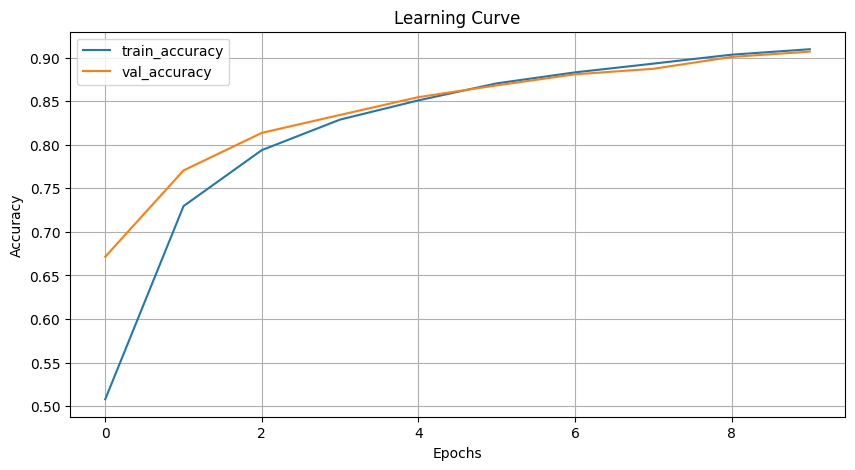

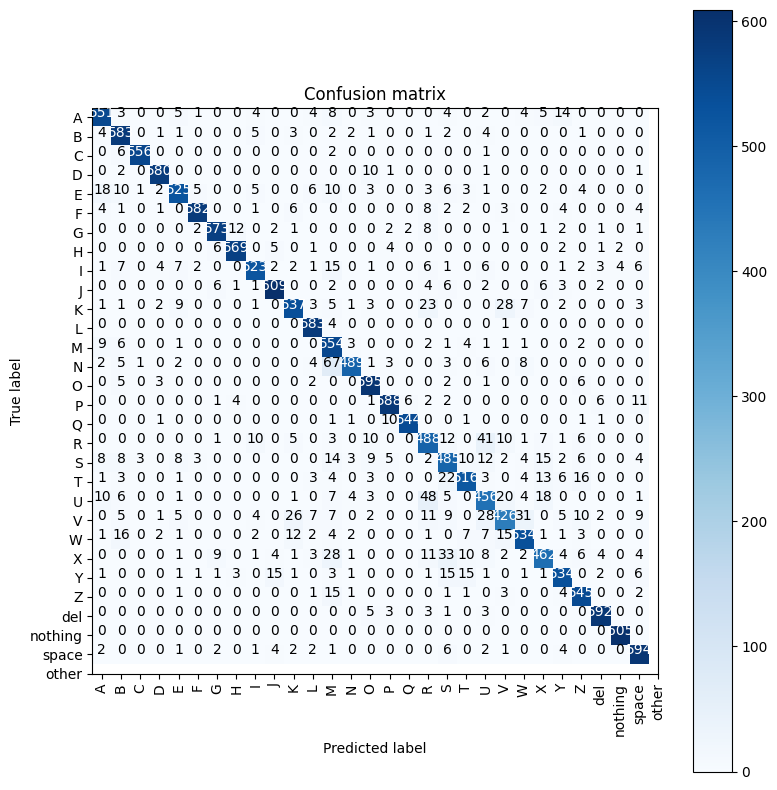

Model saved to my_model.h5


<Functional name=functional_2, built=True>

In [14]:
import numpy as np
from sklearn.utils import class_weight
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense
import keras
import sklearn.metrics
from sklearn.metrics import confusion_matrix

# Assuming y_trainHot is one-hot encoded, extract the original class labels
y_train_labels = np.argmax(y_trainHot, axis=1)  # Convert one-hot to class labels
y_test_labels = np.argmax(y_testHot, axis=1)    # Convert test one-hot to class labels

# Compute class weights using the original labels
class_weight1 = class_weight.compute_class_weight('balanced', 
                                                   classes=np.unique(y_train_labels), 
                                                   y=y_train_labels)

# Convert class_weight1 to a dictionary if necessary
class_weight_dict = dict(enumerate(class_weight1))
map_characters1 = map_characters
# Load pretrained model weights
weight_path1 = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights=weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))

# Define optimizers
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(learning_rate=0.0001)  # Updated argument

def pretrainedNetwork(xtrain, ytrain, xtest, ytest, pretrainedmodel, pretrainedweights, classweight, numclasses, numepochs, optimizer, labels, model_save_path):
    base_model = pretrained_model_1  # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    # Define callbacks
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]

    model.summary()

    # Fit model
    history = model.fit(xtrain, ytrain, 
                        epochs=numepochs, 
                        class_weight=classweight, 
                        validation_data=(xtest, ytest), 
                        verbose=1,
                        callbacks=callbacks_list)
    
    # Evaluate model
    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')

    y_pred = model.predict(xtest)

    # Ensure labels match
    y_true_classes = np.argmax(ytest, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Use the correct number of target names
    target_names = list(labels.values())[:len(np.unique(y_true_classes))]  # Adjust target_names based on unique classes

    print('\n', sklearn.metrics.classification_report(y_true_classes, 
           y_pred_classes, 
           target_names=target_names), sep='') 
    
    Y_pred_classes = np.argmax(y_pred, axis=1) 
    Y_true = np.argmax(ytest, axis=1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    
    # Plotting functions based on history object
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes=list(labels.values()))
    plt.show()

    # Save the model
    model.save(model_save_path)  # Save the entire model
    print(f'Model saved to {model_save_path}')

    return model

# Function to plot learning curve based on history
def plot_learning_curve(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

# Define the path to save the model
model_save_path = 'my_model.h5'  # Change the filename as needed

# Call the pretrainedNetwork function with the save path
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,
                  pretrained_model_1, weight_path1, class_weight_dict, 
                  30, 10, optimizer1, map_characters1, model_save_path)



In [17]:
import cv2
import numpy as np
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input

# Load the trained model
model = load_model('my_model.h5')

# Re-compile the model to ensure metrics are built
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a dictionary to map predicted labels to characters
map_characters = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 
                  7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 
                  13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 
                  19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}

# Initialize webcam (try different indexes if 0 doesn't work)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Define the region of interest (ROI) dimensions
roi_top, roi_bottom, roi_right, roi_left = 100, 400, 350, 650  # Customize these values

# Set the model input size (should match the training input size)
imageSize = 224

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image.")
        break

    # Flip the frame horizontally (optional)
    frame = cv2.flip(frame, 1)

    # Define the Region of Interest (ROI) on the frame
    roi = frame[roi_top:roi_bottom, roi_right:roi_left]
    
    # Draw a rectangle around the ROI (for visualizing)
    cv2.rectangle(frame, (roi_right, roi_top), (roi_left, roi_bottom), (0, 255, 0), 2)

    # Preprocess the ROI: resize, convert to array, and normalize
    roi_resized = cv2.resize(roi, (imageSize, imageSize))
    roi_array = np.array(roi_resized, dtype='float32')
    roi_array = np.expand_dims(roi_array, axis=0)
    roi_array = preprocess_input(roi_array)  # Preprocessing for VGG16

    # Make prediction
    pred = model.predict(roi_array)
    pred_class = np.argmax(pred)  # Get the index of the highest probability
    pred_character = map_characters[pred_class]  # Map the predicted index to the corresponding character

    # Annotate the frame with the prediction
    cv2.putText(frame, pred_character, (roi_right, roi_top - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # Display the frame with the ROI and the prediction
    cv2.imshow('Sign Language Recognition', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()


Error: Could not open webcam.
Error: Failed to capture image.


[ WARN:0@10581.185] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@10581.185] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


In [16]:
from keras.models import load_model

# Load the model
loaded_model = load_model('my_model.h5')
print("Model loaded successfully.")


Model loaded successfully.
